Importing libraries

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import os
from google.colab.patches import cv2_imshow
from scipy.ndimage import rotate

Preparing data and folders

In [2]:
%%capture
if(os.path.isdir('/content/training_data') == False):
  os.mkdir('/content/training_data')
if(os.path.isdir('/content/testing_data') == False):
  os.mkdir('/content/testing_data')

_train_data_url_ = 'https://raw.githubusercontent.com/aaaaqa/face-detection/testing/train_data.zip'
_test_data_url_ = 'https://raw.githubusercontent.com/aaaaqa/face-detection/testing/test_data.zip'
!wget -P /content/training_data '{_train_data_url_}'
!wget -P /content/testing_data '{_test_data_url_}'
!7z x /content/training_data/train_data.zip -o/content/training_data/
!7z x /content/testing_data/test_data.zip -o/content/testing_data/
!rm /content/testing_data/test_data.zip
!rm /content/training_data/train_data.zip

Gathering data into variables

In [3]:
def _gathering_dataset_(directory):
  return tf.keras.utils.image_dataset_from_directory(directory, batch_size=1, image_size=(48,48), color_mode='grayscale', seed=123)

training_dataset = _gathering_dataset_('/content/training_data/')
train_class_names = training_dataset.class_names
num_classes = len(training_dataset.class_names)

training_dataset = training_dataset.unbatch()
x_train, y_train = list(zip(*training_dataset))

testing_dataset = _gathering_dataset_('/content/testing_data/')
testing_dataset = testing_dataset.unbatch()
x_test, y_test = list(zip(*testing_dataset))

Found 24282 files belonging to 5 classes.
Found 5937 files belonging to 5 classes.


In [4]:
train_class_names

['angry', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
y_train_ = []
for i in range(len(y_train)):
  y_train_.append(train_class_names[y_train[i]])

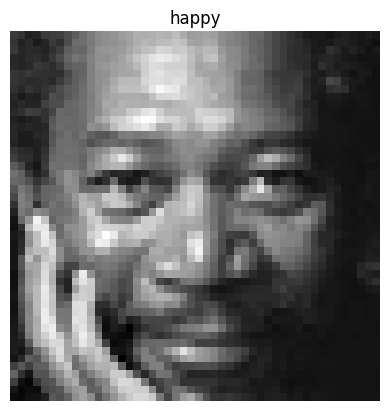

In [6]:
plt.imshow(x_train[0], cmap='gray')
plt.title(y_train_[0])
plt.axis('off')
plt.show()

# Data augmentation



In [16]:
%%capture
x_augmented = np.array(x_train) / 255.
y_augmented = list(y_train)

# Image augmentations
rotations = [np.rot90(image, k=i) for i in range(1, 4) for image in x_augmented]
flipped_images = [np.flip(image, 1) for image in x_augmented]
angle_rotations = [rotate(image, angle=a, reshape=False) for a in [45, 135] for image in x_augmented]

# Combine original and augmented data
augmentation_results = list(itertools.chain(x_augmented, rotations, flipped_images, angle_rotations))
x_augmented = np.array(augmentation_results)

y_augmented = np.array(y_augmented * 7)
y_augmented = tf.keras.utils.to_categorical(y_augmented, num_classes=num_classes)

In [17]:
%%capture
x_test_augmented = np.array(x_test) / 255.
y_test_augmented = list(y_test)

# Image augmentations
rotations = [np.rot90(image, k=i) for i in range(1, 4) for image in x_test_augmented]
flipped_images = [np.flip(image, 1) for image in x_test_augmented]
angle_rotations = [rotate(image, angle=a, reshape=False) for a in [45, 135] for image in x_test_augmented]

# Combine original and augmented data
augmentation_results = list(itertools.chain(x_test_augmented, rotations, flipped_images, angle_rotations))
x_test_augmented = np.array(augmentation_results)

# Update y_test_augmented
y_test_augmented = np.array(y_test_augmented * 7)
y_test_augmented = tf.keras.utils.to_categorical(y_test_augmented, num_classes=num_classes)

In [18]:
print(len(x_augmented), len(y_augmented))

169974 169974


# Creating model

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(48,48,1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [20]:
hist = model.fit(x=x_augmented,y=y_augmented,epochs=50,batch_size=32)

Epoch 1/50
5312/5312 [==============================] - 88s 13ms/step - loss: 1.5622 - accuracy: 0.3152
Epoch 2/50
5312/5312 [==============================] - 69s 13ms/step - loss: 1.3233 - accuracy: 0.4475
Epoch 3/50
5312/5312 [==============================] - 70s 13ms/step - loss: 1.2043 - accuracy: 0.5083
Epoch 4/50
5312/5312 [==============================] - 70s 13ms/step - loss: 1.1401 - accuracy: 0.5408
Epoch 5/50
5312/5312 [==============================] - 69s 13ms/step - loss: 1.1016 - accuracy: 0.5603
Epoch 6/50
5312/5312 [==============================] - 69s 13ms/step - loss: 1.0779 - accuracy: 0.5704
Epoch 7/50
5312/5312 [==============================] - 70s 13ms/step - loss: 1.0550 - accuracy: 0.5823
Epoch 8/50
5312/5312 [==============================] - 70s 13ms/step - loss: 1.0408 - accuracy: 0.5875
Epoch 9/50
5312/5312 [==============================] - 70s 13ms/step - loss: 1.0293 - accuracy: 0.5926
Epoch 10/50
5312/5312 [==============================] - 69s 13m

# Data augmentation testing

# Test evaluation

In [22]:
score = model.evaluate(x_test_augmented, y_test_augmented)

1299/1299 [==============================] - 5s 4ms/step - loss: 0.8372 - accuracy: 0.6729


In [21]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
